# LSTM
The purpose of this notebook is to use XGBoost for predicting hourly bike demand by station.

In [1]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from sklearn import datasets, svm

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

## Data Analysis and Exploration

In [2]:
# Import data
df = pd.read_csv('data/bike_temp_clean.csv')
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df.head()

,num_trips,start_datetime,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
0,0.0,2019-05-08,3185,0.0,1.0,1.0,0.0,2.0,5.0,6.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
1,1.0,2019-05-08,3638,518.0,4.0,0.0,0.0,4.0,8.0,2.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
2,0.0,2019-05-08,3681,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
3,0.0,2019-05-08,3206,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
4,1.0,2019-05-08,3639,1138.0,0.0,0.0,0.0,0.0,3.0,13.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108120 entries, 0 to 108119
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_trips             108120 non-null  float64       
 1   start_datetime        108120 non-null  datetime64[ns]
 2   start_station_id      108120 non-null  int64         
 3   avg_trip_duration     108120 non-null  float64       
 4   num_trips_1hr         108120 non-null  float64       
 5   num_trips_2hr         108120 non-null  float64       
 6   num_trips_3hr         108120 non-null  float64       
 7   num_trips_4hr         108120 non-null  float64       
 8   num_trips_5hr         108120 non-null  float64       
 9   num_trips_6hr         108120 non-null  float64       
 10  num_trips_24hr        108120 non-null  float64       
 11  num_trips_48hr        108120 non-null  float64       
 12  num_trips_week        108120 non-null  float64       
 13 

In [4]:
df.corr()

,num_trips,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
num_trips,1.000000,-8.651456e-02,0.026238,0.623053,0.412487,0.280602,0.187954,0.126078,0.075991,0.645104,...,-1.095460e-02,-1.382883e-01,-1.350434e-01,1.264729e-02,-2.369475e-02,-2.426448e-03,1.310085e-02,3.067819e-02,1.289355e-01,1.867585e-01
start_station_id,-0.086515,1.000000e+00,-0.008129,-0.086513,-0.086533,-0.086552,-0.086556,-0.086599,-0.086634,-0.087014,...,-4.379510e-15,-5.918962e-16,-2.197016e-16,-1.863306e-15,6.676546e-15,-4.662539e-14,1.731880e-14,1.085718e-13,-9.821399e-17,4.689782e-17
avg_trip_duration,0.026238,-8.128621e-03,1.000000,0.013539,0.014179,0.013591,0.008553,0.005038,0.008570,0.014446,...,1.122812e-03,-2.209293e-02,-1.108456e-02,-7.365955e-03,3.140109e-03,-6.194547e-03,5.173688e-03,-6.137626e-04,-2.142133e-03,1.453659e-02
num_trips_1hr,0.623053,-8.651270e-02,0.013539,1.000000,0.623044,0.412512,0.280734,0.187983,0.125802,0.524449,...,-1.071153e-02,-1.666389e-01,-9.477703e-02,1.289275e-02,-2.244593e-02,-2.432374e-03,1.308366e-02,3.069263e-02,8.853101e-02,1.481493e-01
num_trips_2hr,0.412487,-8.653278e-02,0.014179,0.623044,1.000000,0.623163,0.412760,0.280887,0.187960,0.364094,...,-1.026169e-02,-1.845064e-01,-4.846764e-02,1.254297e-02,-2.120156e-02,-2.330127e-03,1.307567e-02,3.078773e-02,-3.334601e-02,7.564166e-02
num_trips_3hr,0.280602,-8.655248e-02,0.013591,0.412512,0.623163,1.000000,0.623075,0.412556,0.280275,0.256160,...,-1.034247e-02,-1.904579e-01,9.693432e-04,1.172402e-02,-2.108087e-02,-2.376047e-03,1.319408e-02,3.099217e-02,-1.119305e-01,2.083966e-02
num_trips_4hr,0.187954,-8.655564e-02,0.008553,0.280734,0.412760,0.623075,1.000000,0.622783,0.411562,0.174897,...,-1.002687e-02,-1.855824e-01,5.045313e-02,1.060466e-02,-2.200245e-02,-2.377448e-03,1.306356e-02,3.114109e-02,-1.434270e-01,1.079764e-02
num_trips_5hr,0.126078,-8.659940e-02,0.005038,0.187983,0.280887,0.412556,0.622783,1.000000,0.622131,0.122398,...,-8.907878e-03,-1.705455e-01,9.749289e-02,8.081044e-03,-2.451177e-02,-2.119300e-03,1.289841e-02,3.086302e-02,-1.513149e-01,5.952171e-03
num_trips_6hr,0.075991,-8.663401e-02,0.008570,0.125802,0.187960,0.280275,0.411562,0.622131,1.000000,0.080147,...,-5.759783e-03,-1.471379e-01,1.394947e-01,3.841325e-03,-3.008043e-02,-1.818318e-03,1.269827e-02,3.047645e-02,-1.487951e-01,4.244931e-03
num_trips_24hr,0.645104,-8.701449e-02,0.014446,0.524449,0.364094,0.256160,0.174897,0.122398,0.080147,1.000000,...,-6.261705e-03,-1.394011e-01,-1.349887e-01,-1.319319e-03,-2.869935e-02,1.044147e-03,1.245772e-02,2.950819e-02,1.280365e-01,1.883146e-01


In [262]:
df.describe()

,num_trips,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,...,snow_depth,temp_max,temp_min,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month
count,108120.000000,108120.000000,1.081200e+05,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,...,108120.0,108120.000000,108120.000000,1.081200e+05,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000
mean,1.029403,3326.132075,3.791670e+02,1.029403,1.029292,1.029153,1.028811,1.028801,1.029273,1.029652,...,0.0,79.694118,64.611765,-6.545510e-17,0.041667,0.010189,0.135294,-0.054901,-0.063952,6.082353
std,2.432913,188.388673,8.127193e+03,2.432898,2.432888,2.432591,2.431369,2.430834,2.435043,2.435279,...,0.0,9.138228,8.349881,6.922219e-01,0.720487,0.657460,0.741180,0.708103,0.701067,0.800177
min,0.000000,3183.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,48.000000,42.000000,-9.976688e-01,-0.990686,-0.866025,-1.000000,-0.998717,-0.994869,5.000000
25%,0.000000,3201.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,73.000000,59.000000,-6.560249e-01,-0.626438,-0.866025,-0.500000,-0.724793,-0.758758,5.000000
50%,0.000000,3225.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,81.000000,66.000000,-1.224647e-16,0.067607,0.000000,0.500000,-0.101168,-0.050649,6.000000
75%,1.000000,3281.000000,3.440000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,87.000000,71.000000,6.560249e-01,0.725520,0.866025,1.000000,0.651372,0.688967,7.000000
max,70.000000,3792.000000,1.729020e+06,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,...,0.0,95.000000,82.000000,9.976688e-01,1.000000,0.866025,1.000000,0.998717,1.000000,7.000000


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


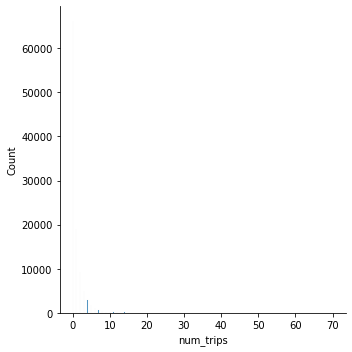

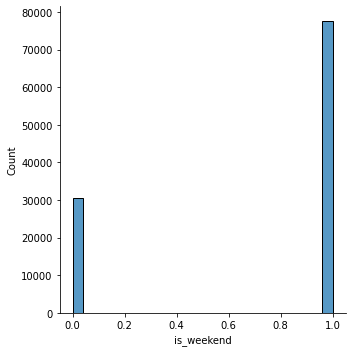

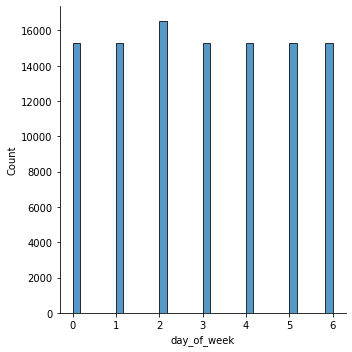

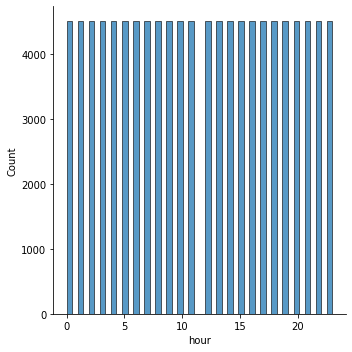

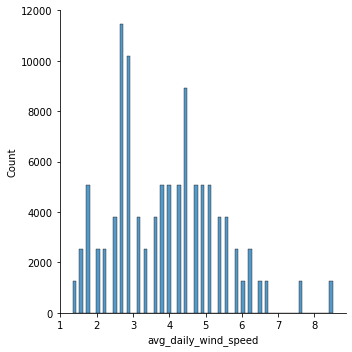

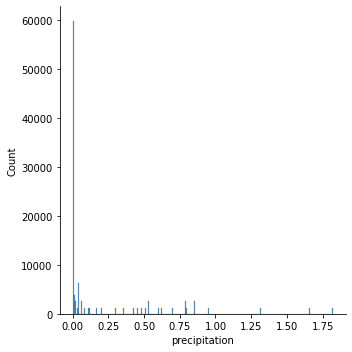

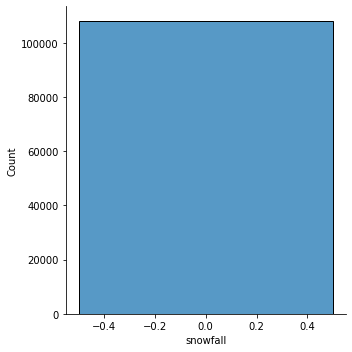

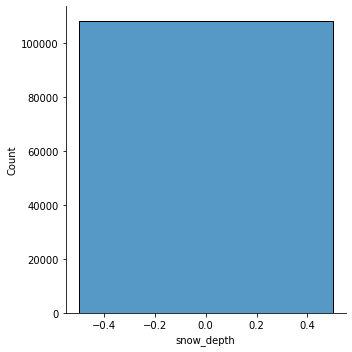

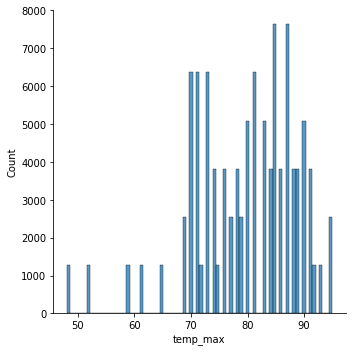

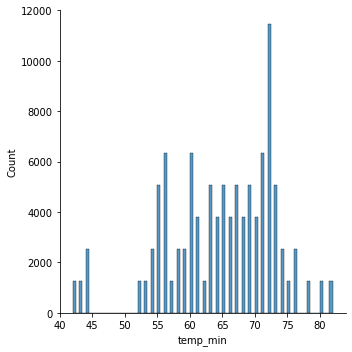

In [263]:
# Plot distribution of num_trips, is_weekend, day_of_week, and hour
sns.displot(df['num_trips'])
sns.displot(df['is_weekend'])
sns.displot(df['day_of_week'])
sns.displot(df['hour'])
sns.displot(df['avg_daily_wind_speed'])
sns.displot(df['precipitation'])
sns.displot(df['snowfall'])
sns.displot(df['snow_depth'])
sns.displot(df['temp_max'])
sns.displot(df['temp_min'])

Note that num_trips does not look like a Gaussian distribution, so lets transform to a logarithmic distribution.

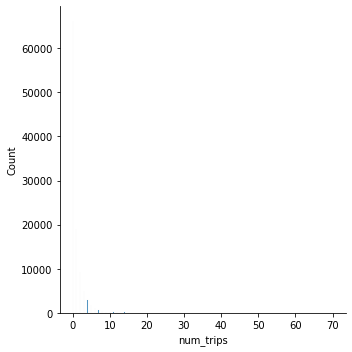

In [264]:
#df['num_trips_log'] = np.log1p(df['num_trips'])
#df = df.reindex(columns=['num_trips', 'num_trips_log', 'start_datetime', 'start_station_id', 'avg_trip_duration', 'is_weekend', 'day_of_week', 'hour'])
sns.displot(df['num_trips'])
#sns.displot(df['num_trips_log'])

Now lets plot the num_trips over time

<AxesSubplot:xlabel='start_datetime'>

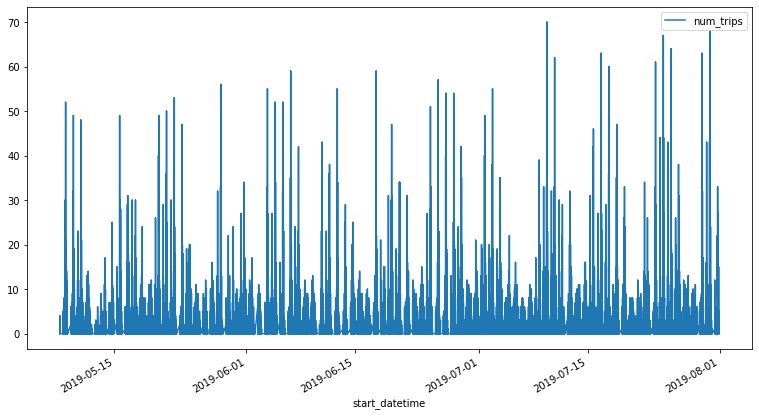

In [246]:
df.plot(x='start_datetime', y='num_trips', figsize=(13,7))

The number of trips appear to increase over the course of the month.

<AxesSubplot:xlabel='hour', ylabel='num_trips'>

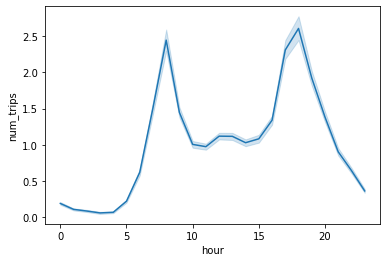

In [81]:
sns.lineplot(data=df, x='hour', y='num_trips')

The distribution of num_trips by hour appears to have two peaks in the AM and PM peak hours

<AxesSubplot:xlabel='start_datetime'>

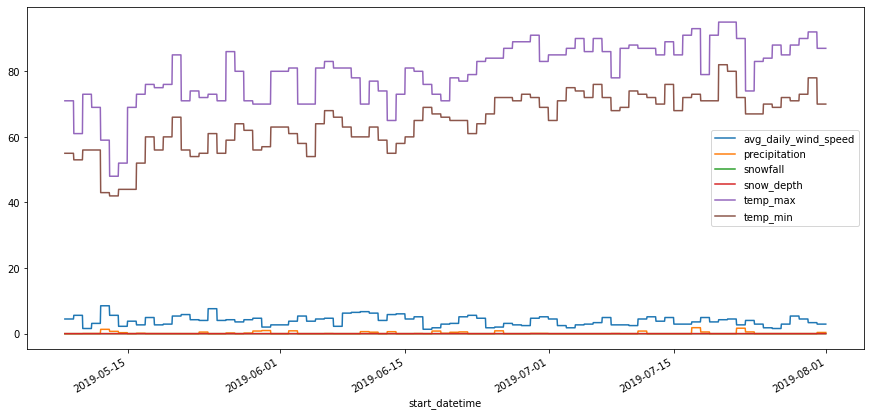

In [82]:
df.plot(x='start_datetime', y=['avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min'], figsize=(15,7))

In [265]:
df.columns

Index(['num_trips', 'start_datetime', 'start_station_id', 'avg_trip_duration',
       'num_trips_1hr', 'num_trips_2hr', 'num_trips_3hr', 'num_trips_4hr',
       'num_trips_5hr', 'num_trips_6hr', 'num_trips_24hr', 'num_trips_48hr',
       'num_trips_week', 'day_of_week', 'day_of_month', 'is_weekend', 'hour',
       'avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth',
       'temp_max', 'temp_min', 'fog', 'heavy_fog', 'thunder', 'haze',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'day_of_month_sin', 'day_of_month_cos', 'month', 'is_am_peak',
       'is_pm_peak'],
      dtype='object')

<AxesSubplot:>

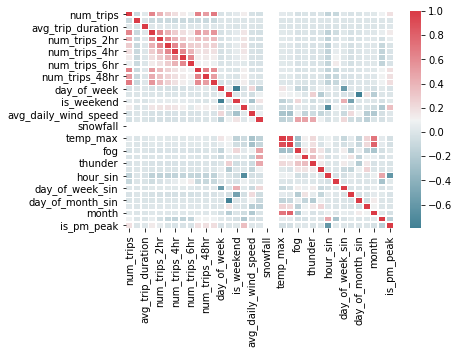

In [248]:
# Plot heatmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), cmap=cmap, linewidths=0.5)

Note that is_weekend and day_of_week are correlated and temp_min and temp_max are correlated. We should likely choose just one of them, but we will test this out with the XGBoost model and importance scores.

## Feature Engineering

In [227]:
# Now drop the start_datetime column as we no longer need it
#df.drop(columns=['start_datetime'], inplace=True)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108120 entries, 0 to 108119
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_trips             108120 non-null  float64       
 1   start_datetime        108120 non-null  datetime64[ns]
 2   start_station_id      108120 non-null  int64         
 3   avg_trip_duration     108120 non-null  float64       
 4   num_trips_1hr         108120 non-null  float64       
 5   num_trips_2hr         108120 non-null  float64       
 6   num_trips_3hr         108120 non-null  float64       
 7   num_trips_4hr         108120 non-null  float64       
 8   num_trips_5hr         108120 non-null  float64       
 9   num_trips_6hr         108120 non-null  float64       
 10  num_trips_24hr        108120 non-null  float64       
 11  num_trips_48hr        108120 non-null  float64       
 12  num_trips_week        108120 non-null  float64       
 13 

In [81]:
# To use LSTM, we have to convert int to float64 types
#df['start_station_id'] = df['start_station_id'].astype('Float64')
df['day_of_week'] = df['day_of_week'].astype('Float64')
df['day_of_month'] = df['day_of_month'].astype('Float64')
df['hour'] = df['hour'].astype('Float64')
df['temp_max'] = df['temp_max'].astype('Float64')
df['temp_max'] = df['temp_max'].astype('Float64')
df['temp_min'] = df['temp_min'].astype('Float64')
df['month'] = df['month'].astype('Float64')

In [384]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108120 entries, 0 to 108119
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_trips             108120 non-null  float64       
 1   start_datetime        108120 non-null  datetime64[ns]
 2   start_station_id      108120 non-null  Float64       
 3   avg_trip_duration     108120 non-null  float64       
 4   num_trips_1hr         108120 non-null  float64       
 5   num_trips_2hr         108120 non-null  float64       
 6   num_trips_3hr         108120 non-null  float64       
 7   num_trips_4hr         108120 non-null  float64       
 8   num_trips_5hr         108120 non-null  float64       
 9   num_trips_6hr         108120 non-null  float64       
 10  num_trips_24hr        108120 non-null  float64       
 11  num_trips_48hr        108120 non-null  float64       
 12  num_trips_week        108120 non-null  float64       
 13 

## Train LSTM Model

### Testing Train/Test Sizes

In [69]:
# Split data into X, y
# X does not need previous counts, as it is included in LSTM
X = df.iloc[0:,1:]
X.drop(columns=['num_trips_1hr', 'num_trips_2hr', 'num_trips_3hr', 'num_trips_4hr', 'num_trips_5hr', 'num_trips_6hr', 'num_trips_24hr', 'num_trips_48hr', 'num_trips_week'], inplace=True)

y = df.iloc[:,0:3]
y.reindex(columns=['start_datetime', 'start_station_id', 'num_trips'])

best_split = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)

In [178]:
# LSTMs generally benefit from scaling the 

#f_columns = ['avg_trip_duration', 'avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min', 'num_trips_1hr', 'num_trips_2hr', 'num_trips_3hr', 'num_trips_4hr', 'num_trips_5hr', 'num_trips_6hr', 'num_trips_24hr', 'num_trips_48hr', 'num_trips_week']
f_columns = ['avg_trip_duration', 'avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min']
cnt_columns = ['num_trips']

# feature, count transformers
# NOTE: Only scale the training data, we should not do this to the test data as it should be simulated as a dataset we do not know anything about
f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(X_train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(y_train[cnt_columns].to_numpy())

# Training data
X_train.loc[:,f_columns] = f_transformer.transform(X_train[f_columns].to_numpy())
y_train.loc[:,cnt_columns] = cnt_transformer.transform(y_train[cnt_columns].to_numpy())

# Test data
X_test.loc[:,f_columns] = f_transformer.transform(X_test[f_columns].to_numpy())
y_test.loc[:,cnt_columns] = cnt_transformer.transform(y_test[cnt_columns].to_numpy())

/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: Se

In [39]:
# Creates time-series data using subsequences
def create_dataset_start_station(X, y, time_steps, start_station_id):
    Xs, ys = [], []
    
    # Add start_datetime to y, so we can subsequence based on time
    y['start_datetime'] = X['start_datetime']
    y['start_station_id'] = X['start_station_id']
    
    # Determine total number of hours
    min_datetime = X.start_datetime.min()
    max_datetime = X.start_datetime.max()
    diff = max_datetime - min_datetime
    total_hours = int(((diff.days)*24) + (diff.seconds / 3600))

    i = 0
    for i in range(total_hours - time_steps):
        start_datetime = min_datetime + pd.Timedelta(hours=i)
        end_datetime = start_datetime + pd.Timedelta(hours=time_steps)
        # Append sequence to Xs
        vX = X.loc[(X['start_datetime'] >= start_datetime) & (X['start_datetime'] < end_datetime) & (X['start_station_id']==start_station_id)]
        vX.drop(columns=['start_datetime', 'start_station_id'], inplace=True)
        Xs.append(vX.values)
        # Append sequence to ys
        vy = y.loc[(y['start_datetime'] == end_datetime) & (y['start_station_id'] == start_station_id)]
        vy.drop(columns=['start_datetime', 'start_station_id'], inplace=True)
        ys.append(vy.values[0][0])

        i += 1
        
    return np.asarray(Xs).astype(np.float32), np.asarray(ys).astype(np.float32)




# # Creates time-series data using subsequences
# def create_dataset(X, y, time_steps):
#     Xs, ys = [], []
    
#     # Add start_datetime to y, so we can subsequence based on time
#     y['start_datetime'] = X['start_datetime']
    
#     # Determine total number of hours
#     min_datetime = X.start_datetime.min()
#     max_datetime = X.start_datetime.max()
#     diff = max_datetime - min_datetime
#     total_hours = int(((diff.days)*24) + (diff.seconds / 3600))

#     i = 0
#     for i in range(total_hours - time_steps):
#         start_datetime = min_datetime + pd.Timedelta(hours=i)
#         end_datetime = start_datetime + pd.Timedelta(hours=time_steps)
#         # Append sequence to Xs
#         vX = X.loc[(X['start_datetime'] >= start_datetime) & (X['start_datetime'] < end_datetime)]
#         vX.drop(columns=['start_datetime'], inplace=True)
#         Xs.append(vX.values)
#         # Append sequence to ys
#         vy = y.loc[(y['start_datetime'] == end_datetime)]
#         vy.drop(columns=['start_datetime'], inplace=True)
#         ys.append(vy.values)

#         i += 1
        
#     return np.asarray(Xs).astype(np.float32), np.asarray(ys).astype(np.float32)

In [48]:
# Creates time-series data using subsequences
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    
    # Pivot X so there is one timestep for all combined station/variable combos
    X = X.pivot(index='start_datetime', columns='start_station_id', values=X.columns[2:])
    X.columns = ['%s%s' % (b, '|%s' % a if b else '') for a, b in X.columns]
    X.reset_index(inplace=True)
    # Pivot y so there is one timestep for all combined stations
    y = y.pivot(index='start_datetime', columns='start_station_id', values=['num_trips'])
    y.columns = ['%s%s' % (b, '|%s' % a if b else '') for a, b in y.columns]
    y.reset_index(inplace=True)
    
    # Determine total number of hours
    min_datetime = X.start_datetime.min()
    max_datetime = X.start_datetime.max()
    diff = max_datetime - min_datetime
    total_hours = int(((diff.days)*24) + (diff.seconds / 3600))

    i = 0
    for i in range(total_hours - time_steps):
        start_datetime = min_datetime + pd.Timedelta(hours=i)
        end_datetime = start_datetime + pd.Timedelta(hours=time_steps)
        # Get all X values >= start_datetime and < end_datetime
        vX = X.loc[(X['start_datetime'] >= start_datetime) & (X['start_datetime'] < end_datetime)]
        vX.drop(columns=['start_datetime'], inplace=True)
        Xs.append(vX.values)
        
        # Append sequence to ys
        vy = y.loc[(y['start_datetime'] == end_datetime)]
        vy.drop(columns=['start_datetime'], inplace=True)
        ys.append(vy.values)

        i += 1
        
    return np.asarray(Xs).astype(np.float32), np.asarray(ys).astype(np.float32)
    return Xs, ys

In [70]:
X_train, y_train = create_dataset(X_train, y_train, 168)
X_test, y_test = create_dataset(X_test, y_test, 168)

In [50]:
X_train.shape

(1463, 168, 1272)

In [51]:
y_train.shape

(1463, 1, 53)

In [52]:
X_test.shape

(239, 168, 1272)

In [53]:
y_test.shape

(239, 1, 53)

## Build Single-Output LSTM Model

In [84]:
# Custom rmse function
from keras import backend as K

# def rmse(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [17]:
# FOR SHAPES
# https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc
# CNN-LSTM https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

# model = keras.Sequential()
# model.add(
#   # First layer is bidirectional layer
#   #keras.layers.Bidirectional(
#     # In bidirectional layer, put in LSTM layer
#     keras.layers.LSTM(
#       # Number of neurons model will have
#       units=128, 
#       # input_shape of neural network
#       input_shape=(X_train.shape[1], X_train.shape[2])
#     )
#   #)
# )
# # Add dropout layer to penalize more complex models
# model.add(keras.layers.Dropout(rate=0.2))
# # Output layer with a single neuron
# model.add(keras.layers.Dense(units=1))

# # Compile, compare with MSE
# # adam optimizer
# model.compile(loss=rmse, optimizer='adam')



def build_model():
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
      # First layer is bidirectional layer
      keras.layers.Bidirectional(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Number of neurons model will have
          units=128, 
          # input_shape of neural network
          input_shape=(X_train.shape[1], X_train.shape[2])
        )
      )
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    #model.compile(loss='mse', optimizer='adam')
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    
    return model
    

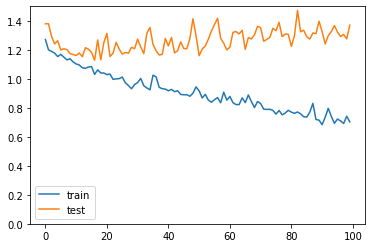

In [19]:
# # Plot loss
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# axes = plt.gca()
# axes.set_ylim([0,1.5])
# plt.legend();

In [54]:
def root_mean_squared_error(y_true, y_pred):
        rmse_tensor = K.sqrt(K.mean(K.square(y_pred - y_true))) 
        rmse_number = rmse_tensor
        return rmse_number

# Sequential allows us to stack multiple layers on top of each other
model = keras.Sequential()
model.add(
  # First layer is bidirectional layer
  keras.layers.Bidirectional(
    # In bidirectional layer, put in LSTM layer
    keras.layers.LSTM(
      # Number of neurons model will have
      units=128, 
      # input_shape of neural network
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
# Add dropout layer to penalize more complex models
model.add(keras.layers.Dropout(rate=0.2))
# Output layer with 53 neurons as we are predicting 53 stations
model.add(keras.layers.Dense(53))
#model.compile(loss='mse', optimizer='adam')
model.compile(loss=root_mean_squared_error, optimizer='adam')

In [55]:
# Validation split

history = model.fit(
    X_train, y_train,
    # Training data will be seen 30 times by model
    epochs=3,
    # number of samples our model will take when training from a single step
    batch_size=32,
    # Some of training data used for validation
    validation_split=0.2,
    # Do not shuffle data, because time-series data
    shuffle=False
)

Epoch 1/3
37/37 [==============================] - 19s 421ms/step - loss: 2.2788 - val_loss: 2.1093
Epoch 2/3
37/37 [==============================] - 17s 457ms/step - loss: 2.1657 - val_loss: 2.0932
Epoch 3/3
37/37 [==============================] - 17s 453ms/step - loss: 2.1506 - val_loss: 2.0881


In [58]:
y_pred = model.predict(X_test)
y_pred = [item for sublist in y_pred for item in sublist]
y_pred = np.array(y_pred)

In [59]:
y_pred

array([0.0524255 , 1.8298022 , 1.5287821 , ..., 0.08215407, 0.37741923,
       0.4823682 ], dtype=float32)

In [78]:
y_test_one = y_test
y_test_one = [item for sublist in y_test_one for item in sublist]
y_test_one = [item for sublist in y_test_one for item in sublist]
y_test_one = np.array(y_test_one)

In [85]:
rmse(y_test_one, y_pred)

2.6590984

In [193]:
model.output_shape
model.output

AttributeError: 'Sequential' object has no attribute '_nested_outputs'

### LSTM Model tuning

In [16]:
# https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

# https://github.com/kamran786/Bike-Sharing-Demand-Using-Tensorflow/blob/master/BikeSharing_Tensorflow.ipynb
# Implemented different 
# - Activation functions, 
# - Cost functions, 
# - Hidden layers, 
# - Hidden neurons, 
# - Gradient estimation, 
# - number of epochs, 
# - Network initialization 
# to improve the model accuracy.

# https://www.sciencedirect.com/science/article/pii/S1319157820303505
# On building the LSTM model, many hyper-parameters like activation function, loss function, and optimizer need to be set in advance. These hyper-parameters play a significant role in the performance of the DNNs.

# https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/
# Tuning number of epochs, batches, number of neurons


#### Number of epochs

In [86]:
# NOTE: build_fn must be a callable
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    #'epochs' : [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'epochs' : [1],
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

46/46 [==============================] - 20s 368ms/step - loss: 2.2827
BEST PARAMS: {'epochs': 1}

-2.192 (+/-0.163) for {'epochs': 1}


Using 10 epochs reduces the RMSE the most.

#### Validation Split

In [101]:
parameters = {
    'epochs' : [10],
    'validation_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

Epoch 1/10
33/33 [==============================] - 6s 110ms/step - loss: 1.7831 - val_loss: 1.4445
Epoch 2/10
33/33 [==============================] - 4s 108ms/step - loss: 1.6505 - val_loss: 1.4342
Epoch 3/10
33/33 [==============================] - 3s 103ms/step - loss: 1.6381 - val_loss: 1.4137
Epoch 4/10
33/33 [==============================] - 3s 101ms/step - loss: 1.6060 - val_loss: 1.4206
Epoch 5/10
33/33 [==============================] - 3s 106ms/step - loss: 1.6053 - val_loss: 1.4298
Epoch 6/10
33/33 [==============================] - 3s 102ms/step - loss: 1.6144 - val_loss: 1.4173
Epoch 7/10
33/33 [==============================] - 3s 106ms/step - loss: 1.5861 - val_loss: 1.3671
Epoch 8/10
33/33 [==============================] - 3s 104ms/step - loss: 1.6244 - val_loss: 1.3988
Epoch 9/10
33/33 [==============================] - 3s 103ms/step - loss: 1.5908 - val_loss: 1.3912
Epoch 10/10
33/33 [==============================] - 4s 107ms/step - loss: 1.6100 - val_loss: 1.3805

30/30 [==============================] - 3s 107ms/step - loss: 1.3033 - val_loss: 1.5172
Epoch 4/10
30/30 [==============================] - 3s 106ms/step - loss: 1.3765 - val_loss: 1.5785
Epoch 5/10
30/30 [==============================] - 3s 108ms/step - loss: 1.3373 - val_loss: 1.5570
Epoch 6/10
30/30 [==============================] - 3s 112ms/step - loss: 1.3100 - val_loss: 1.6085
Epoch 7/10
30/30 [==============================] - 3s 101ms/step - loss: 1.3099 - val_loss: 1.5228
Epoch 8/10
30/30 [==============================] - 3s 103ms/step - loss: 1.2908 - val_loss: 1.5527
Epoch 9/10
30/30 [==============================] - 3s 104ms/step - loss: 1.2696 - val_loss: 1.5685
Epoch 10/10
30/30 [==============================] - 3s 100ms/step - loss: 1.2822 - val_loss: 1.5224
Epoch 1/10
30/30 [==============================] - 5s 111ms/step - loss: 1.5368 - val_loss: 1.9404
Epoch 2/10
30/30 [==============================] - 3s 98ms/step - loss: 1.4161 - val_loss: 1.9352
Epoch 3/10


Epoch 5/10
22/22 [==============================] - 3s 144ms/step - loss: 1.4469 - val_loss: 1.7634
Epoch 6/10
22/22 [==============================] - 4s 172ms/step - loss: 1.3851 - val_loss: 1.7561
Epoch 7/10
22/22 [==============================] - 3s 150ms/step - loss: 1.3181 - val_loss: 1.7774
Epoch 8/10
22/22 [==============================] - 3s 161ms/step - loss: 1.3239 - val_loss: 1.7934
Epoch 9/10
22/22 [==============================] - 4s 181ms/step - loss: 1.3197 - val_loss: 1.7751
Epoch 10/10
22/22 [==============================] - 5s 209ms/step - loss: 1.3118 - val_loss: 1.7974
Epoch 1/10
22/22 [==============================] - 5s 138ms/step - loss: 1.7528 - val_loss: 1.8301
Epoch 2/10
22/22 [==============================] - 3s 120ms/step - loss: 1.4752 - val_loss: 1.8098
Epoch 3/10
22/22 [==============================] - 3s 130ms/step - loss: 1.3564 - val_loss: 1.7979
Epoch 4/10
22/22 [==============================] - 3s 124ms/step - loss: 1.4077 - val_loss: 1.7739

Epoch 7/10
19/19 [==============================] - 3s 144ms/step - loss: 1.2422 - val_loss: 1.5991
Epoch 8/10
19/19 [==============================] - 3s 154ms/step - loss: 1.2235 - val_loss: 1.6225
Epoch 9/10
19/19 [==============================] - 3s 156ms/step - loss: 1.2708 - val_loss: 1.6044
Epoch 10/10
19/19 [==============================] - 3s 146ms/step - loss: 1.1903 - val_loss: 1.6060
Epoch 1/10
15/15 [==============================] - 5s 167ms/step - loss: 2.0314 - val_loss: 1.7432
Epoch 2/10
15/15 [==============================] - 2s 143ms/step - loss: 1.4924 - val_loss: 1.7794
Epoch 3/10
15/15 [==============================] - 2s 136ms/step - loss: 1.3925 - val_loss: 1.7392
Epoch 4/10
15/15 [==============================] - 2s 134ms/step - loss: 1.3697 - val_loss: 1.7585
Epoch 5/10
15/15 [==============================] - 2s 137ms/step - loss: 1.2794 - val_loss: 1.7281
Epoch 6/10
15/15 [==============================] - 2s 156ms/step - loss: 1.3658 - val_loss: 1.7299

Epoch 9/10
11/11 [==============================] - 2s 187ms/step - loss: 1.1123 - val_loss: 1.6807
Epoch 10/10
11/11 [==============================] - 2s 179ms/step - loss: 1.0778 - val_loss: 1.6450
Epoch 1/10
11/11 [==============================] - 3s 195ms/step - loss: 2.0626 - val_loss: 1.7974
Epoch 2/10
11/11 [==============================] - 2s 172ms/step - loss: 1.3028 - val_loss: 1.4667
Epoch 3/10
11/11 [==============================] - 2s 164ms/step - loss: 1.3001 - val_loss: 1.4646
Epoch 4/10
11/11 [==============================] - 2s 192ms/step - loss: 1.2415 - val_loss: 1.4643
Epoch 5/10
11/11 [==============================] - 2s 170ms/step - loss: 1.2262 - val_loss: 1.4559
Epoch 6/10
11/11 [==============================] - 2s 232ms/step - loss: 1.2521 - val_loss: 1.4449
Epoch 7/10
11/11 [==============================] - 2s 194ms/step - loss: 1.2247 - val_loss: 1.4482
Epoch 8/10
11/11 [==============================] - 2s 210ms/step - loss: 1.1941 - val_loss: 1.4740

4/4 [==============================] - 1s 464ms/step - loss: 1.3306 - val_loss: 1.6289
Epoch 3/10
4/4 [==============================] - 1s 409ms/step - loss: 1.3858 - val_loss: 1.5805
Epoch 4/10
4/4 [==============================] - 1s 423ms/step - loss: 1.2289 - val_loss: 1.5729
Epoch 5/10
4/4 [==============================] - 2s 576ms/step - loss: 1.2630 - val_loss: 1.5796
Epoch 6/10
4/4 [==============================] - 2s 662ms/step - loss: 1.2783 - val_loss: 1.5715
Epoch 7/10
4/4 [==============================] - 2s 701ms/step - loss: 1.3226 - val_loss: 1.5537
Epoch 8/10
4/4 [==============================] - 2s 655ms/step - loss: 1.2238 - val_loss: 1.5573
Epoch 9/10
4/4 [==============================] - 2s 636ms/step - loss: 1.1416 - val_loss: 1.5330
Epoch 10/10
4/4 [==============================] - 2s 599ms/step - loss: 1.1328 - val_loss: 1.5246
Epoch 1/10
4/4 [==============================] - 4s 549ms/step - loss: 1.6741 - val_loss: 1.6328
Epoch 2/10
4/4 [==============

Using a 0.1 validation split resulted in the best model, but 0.2 was not significantly worse. Thus, we will use 0.2 to prevent overfitting.

#### Optimizer

In [ ]:
parameters = {
    'epochs' : [10],
    'validation_split': [0.2],
    #'optimizer': ['adam', 'Adadelta']
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

Epoch 1/10
30/30 [==============================] - 201s 7s/step - loss: 7.3861 - val_loss: 5.7384
Epoch 2/10
30/30 [==============================] - 190s 6s/step - loss: 5.9873 - val_loss: 5.4137
Epoch 3/10
30/30 [==============================] - 189s 6s/step - loss: 5.9116 - val_loss: 5.4099
Epoch 4/10
30/30 [==============================] - 203s 7s/step - loss: 5.8612 - val_loss: 5.4110
Epoch 5/10
30/30 [==============================] - 211s 7s/step - loss: 5.8659 - val_loss: 5.4098
Epoch 6/10
30/30 [==============================] - 203s 7s/step - loss: 5.8792 - val_loss: 5.4099
Epoch 7/10
30/30 [==============================] - 206s 7s/step - loss: 5.8715 - val_loss: 5.4133
Epoch 8/10
30/30 [==============================] - 195s 7s/step - loss: 5.8746 - val_loss: 5.4100
Epoch 9/10
30/30 [==============================] - 190s 6s/step - loss: 5.8372 - val_loss: 5.4098
Epoch 10/10
30/30 [==============================] - 190s 6s/step - loss: 5.8661 - val_loss: 5.4098
Epoch 1/1

In [ ]:
# What features are included?

In [ ]:
# Number of time steps

In [ ]:
# LSTM Model structure
# TODO - What can go here?
# Dropout rate, number of layers, number of dense layers

In [ ]:
# Activation function
# https://www.sciencedirect.com/science/article/pii/S1319157820303505
# sigmoid, hyperbolic tangent, Rectified Linear Unit (ReLU)

### Predict Test Data

In [126]:
X_test.shape

(239, 168, 24)

In [139]:
# Predict test data
preds = model.predict(X_test).reshape(1,-1)[0]
preds[preds < 0] = 0

In [128]:
preds.shape

(239,)

In [129]:
y_test.shape

(239,)

In [140]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")

RMSE of preds, y_test: 1.8108024597167969


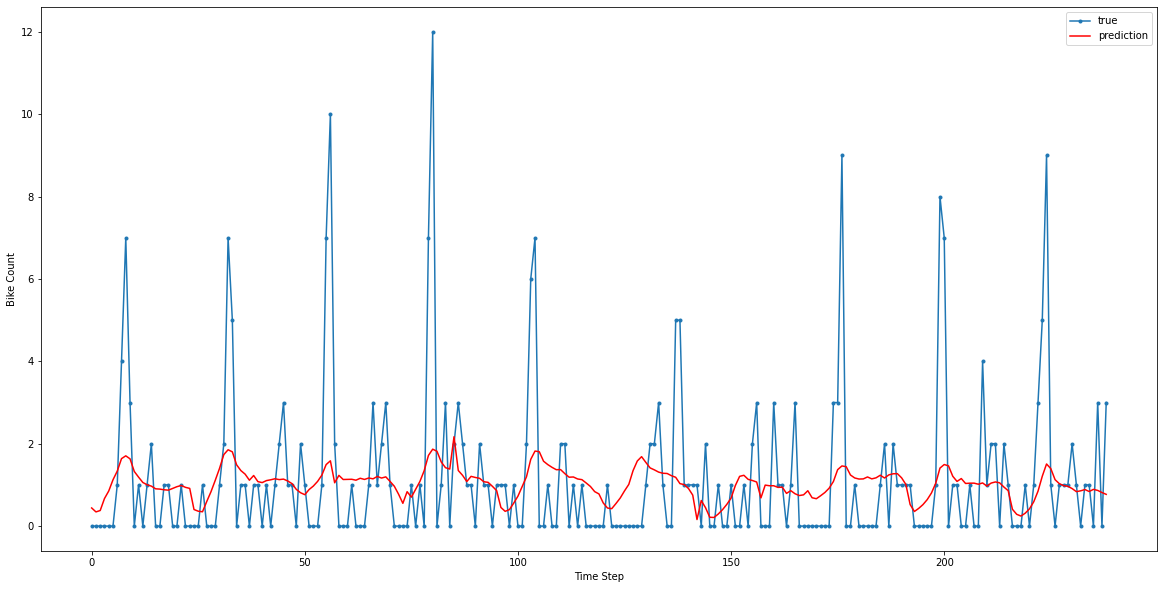

In [132]:
# Median station plot
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(y_test, marker='.', label="true")
plt.plot(preds, 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();